<a href="https://colab.research.google.com/github/juno-yuu/COVID-Vaccine-and-Biotech-industry/blob/Erin/Final_Project_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Github

In [1]:
#!git clone https://github.com/juno-yuu/COVID-Vaccine-and-Biotech-industry.git

### Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')
import requests
import io
import pandas.util.testing as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

### Read Datasets

In [3]:
# vaccination dataset
vacci = pd.read_csv('https://raw.githubusercontent.com/juno-yuu/COVID-Vaccine-and-Biotech-industry/main/us_state_vaccinations.csv', index_col = 0)

# comfirmed
# case_confirmed = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/time_series_covid19_confirmed_US.csv")
case_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

# death
# case_death = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/time_series_covid19_deaths_US.csv")
case_death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

# latest data
# update = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/05-26-2021_us.csv")

# manufacture daily
manu = pd.read_csv("https://raw.githubusercontent.com/xinyanz-erin/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv", index_col = 1)

# stock prices
mrna = pd.read_csv('https://raw.githubusercontent.com/juno-yuu/COVID-Vaccine-and-Biotech-industry/main/MRNA.csv', index_col = 0).rename(str.lower, axis='columns')
pfe = pd.read_csv('https://raw.githubusercontent.com/juno-yuu/COVID-Vaccine-and-Biotech-industry/main/PFE.csv', index_col = 0).rename(str.lower, axis='columns')
jnj = pd.read_csv('https://raw.githubusercontent.com/juno-yuu/COVID-Vaccine-and-Biotech-industry/main/JNJ.csv', index_col = 0).rename(str.lower, axis='columns')

### Check datasets

In [4]:
vacci.head()

,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,
2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222
2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212
2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226
2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN


In [5]:
case_confirmed.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6763,6763,6773,6793,6819,6835,6876,6879,6882,6889,6890,6897,6904,6907,6909,6910,6910,6914,6914,6918,6918,6920,6920,6926,6928,6938,6971,7001,7005,7010,7015,7017,7049,7106,7113,7118,7118,7126,7135,7141
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20723,20730,20764,20787,20815,20833,20838,20847,20863,20875,20897,20921,20941,20966,20983,20993,20993,21035,21093,21107,21123,21131,21135,21154,21170,21191,21290,21392,21411,21422,21444,21467,21489,21511,21535,21546,21554,21578,21593,21606
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2271,2271,2275,2284,2289,2292,2296,2296,2296,2297,2298,2299,2300,2302,2302,2302,2302,2307,2307,2307,2307,2308,2308,2310,2314,2317,2319,2320,2320,2320,2322,2324,2326,2327,2328,2328,2328,2331,2331,2333
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2563,2567,2569,2569,2573,2578,2582,2584,2584,2588,2591,2593,2594,2596,2596,2597,2597,2604,2604,2604,2605,2607,2607,2609,2612,2615,2630,2645,2647,2648,2651,2652,2656,2657,2656,2658,2659,2660,2662,2666
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6532,6532,6548,6556,6563,6570,6570,6571,6574,6581,6595,6607,6613,6616,6619,6621,6621,6635,6645,6651,6656,6660,6661,6678,6680,6694,6750,6771,6773,6776,6794,6808,6816,6826,6829,6832,6832,6847,6856,6862


In [6]:
case_death.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,106,106,106,107,107,107,107,107,107,107,107,107,107,107,107,107,107,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,109,109,110,110,110,110,110,110
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,302,302,302,302,303,303,305,305,305,305,305,305,305,306,306,306,306,307,307,307,308,308,308,308,309,309,309,310,310,310,310,310,310,310,310,310,310,310,310,310
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,56,56,56,56,56,56,56,56,56,56,56,56,56,56,57,57,57,57,57,57,56,56,56,56,56,56,56,56,58,58,58,58,58,58,58,58
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,61,61,61,61,62,62,62,62,62,62,63,63,63,63,63,63,63,63,63,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,133,133,133,133,133,134,134,134,134,134,134,135,135,135,135,135,135,136,136,137,137,137,137,137,137,137,139,139,139,139,139,139,139,139,139,139,139,139,139,139


In [7]:
manu.head()

,location,vaccine,total_vaccinations
date,,,
2020-12-24,Chile,Pfizer/BioNTech,420
2020-12-25,Chile,Pfizer/BioNTech,5198
2020-12-26,Chile,Pfizer/BioNTech,8338
2020-12-27,Chile,Pfizer/BioNTech,8649
2020-12-28,Chile,Pfizer/BioNTech,8649


### Data Cleaning and Combining

In [8]:
mrna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 2020-03-02 to 2021-05-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       304 non-null    float64
 1   high       304 non-null    float64
 2   low        304 non-null    float64
 3   close      304 non-null    float64
 4   adj close  304 non-null    float64
 5   volume     304 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 16.6+ KB


In [9]:
pfe = pfe.rename(columns={'adj close': 'adjclose'})
mrna = mrna.rename(columns={'adj close': 'adjclose'})
jnj = jnj.rename(columns={'adj close': 'adjclose'})

In [10]:
pfe['lagadjclose'] = pfe['adjclose'].shift(1)
pfe = pfe.dropna()
mrna['lagadjclose'] = mrna['adjclose'].shift(1)
mrna = mrna.dropna()
jnj['lagadjclose'] = jnj['adjclose'].shift(1)
jnj = jnj.dropna()

In [11]:
pfe['rtn'] = (pfe.adjclose  - pfe.lagadjclose) / pfe.lagadjclose 
mrna['rtn'] = (mrna.adjclose  - mrna.lagadjclose) / mrna.lagadjclose
jnj['rtn'] = (jnj.adjclose  - jnj.lagadjclose) / jnj.lagadjclose 

In [12]:
manu.location.unique()
manu.vaccine.unique()

array(['Pfizer/BioNTech', 'Sinovac', 'Oxford/AstraZeneca', 'Moderna',
       'Johnson&Johnson'], dtype=object)

In [13]:
Pf_manu = manu.loc[manu.vaccine == 'Pfizer/BioNTech']
Pf_manu = Pf_manu.loc[Pf_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

Mod_manu = manu.loc[manu.vaccine == 'Moderna']
Mod_manu = Mod_manu.loc[Mod_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

JJ_manu = manu.loc[manu.vaccine == 'Johnson&Johnson']
JJ_manu = JJ_manu.loc[JJ_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             9281063
                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             9281063
                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             

In [14]:
# keep stats level data
vacci = vacci[vacci.location != 'United States']
vacci_us = vacci.groupby('date').sum()
vacci_us.head()

,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,
2021-01-12,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-14,12374484.0,35343775.0,10886077.0,0.00,209.66,0.0,178.06,624.62,1011845.0,1047786.0,176936.0,23.766
2021-01-15,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-16,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,947221.5,1083109.0,182231.0,0.000


In [15]:
Pf_manu_vacci = Pf_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
Pf_manu_vacci.head(10)

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-01-12,Pfizer/BioNTech,5488697,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,Pfizer/BioNTech,6025872,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-15,Pfizer/BioNTech,7153268,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-19,Pfizer/BioNTech,8874811,17453029.0,31161075.0,13595803.0,39.95,294.24,2023124.0,252.75,650.16,947221.5,1024875.0,171345.0,31.303
2021-01-20,Pfizer/BioNTech,9281063,18433513.0,35990150.0,14270417.0,43.04,309.90,2161419.0,265.22,716.83,980484.0,1010126.0,166520.0,28.830
2021-01-21,Pfizer/BioNTech,9817027,19635555.0,37960000.0,15053257.0,48.18,330.89,2394961.0,281.05,748.19,1202042.0,1037298.0,173267.0,29.246
2021-01-22,Pfizer/BioNTech,10695066,21397243.0,39892400.0,16243093.0,55.35,359.79,2756953.0,302.55,774.72,1761688.0,1104734.0,183333.0,30.468
2021-01-23,Pfizer/BioNTech,11471457,22975660.0,41411550.0,17390345.0,59.93,384.49,3027865.0,322.48,795.34,1578417.0,1194901.0,196176.0,31.705
2021-01-24,Pfizer/BioNTech,12153536,24415673.0,41411550.0,18502131.0,63.41,410.77,3216836.0,345.12,795.34,1440013.0,1265296.0,211301.0,33.769


In [16]:
Mod_manu_vacci = Mod_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
Mod_manu_vacci.head(10)

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-01-12,Moderna,3835859,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,Moderna,4249795,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-15,Moderna,5122662,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-19,Moderna,6828561,17453029.0,31161075.0,13595803.0,39.95,294.24,2023124.0,252.75,650.16,947221.5,1024875.0,171345.0,31.303
2021-01-20,Moderna,7239750,18433513.0,35990150.0,14270417.0,43.04,309.90,2161419.0,265.22,716.83,980484.0,1010126.0,166520.0,28.830
2021-01-21,Moderna,7724683,19635555.0,37960000.0,15053257.0,48.18,330.89,2394961.0,281.05,748.19,1202042.0,1037298.0,173267.0,29.246
2021-01-22,Moderna,8407909,21397243.0,39892400.0,16243093.0,55.35,359.79,2756953.0,302.55,774.72,1761688.0,1104734.0,183333.0,30.468
2021-01-23,Moderna,9061112,22975660.0,41411550.0,17390345.0,59.93,384.49,3027865.0,322.48,795.34,1578417.0,1194901.0,196176.0,31.705
2021-01-24,Moderna,9689497,24415673.0,41411550.0,18502131.0,63.41,410.77,3216836.0,345.12,795.34,1440013.0,1265296.0,211301.0,33.769


In [17]:
JJ_manu_vacci = JJ_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
JJ_manu_vacci.head()

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-03-08,Johnson&Johnson,208590,103758241.0,122473710.0,62549309.0,612.21,1767.85,32897443.0,1135.82,2398.49,1824650.0,2287671.0,377665.0,48.104
2021-03-09,Johnson&Johnson,308181,105467512.0,129540430.0,63678459.0,623.33,1794.28,33544611.0,1152.60,2507.32,1709271.0,2277293.0,384672.0,46.492
2021-03-10,Johnson&Johnson,458911,107614717.0,134410410.0,65089854.0,639.85,1836.32,34385505.0,1180.36,2583.54,2147205.0,2294866.0,400701.0,46.015
2021-03-11,Johnson&Johnson,638469,110233615.0,137798185.0,66767597.0,658.40,1881.51,35389429.0,1209.30,2644.55,2618898.0,2359359.0,410068.0,46.039
2021-03-12,Johnson&Johnson,873726,113299843.0,140121405.0,68719280.0,681.17,1937.86,36578051.0,1245.49,2681.15,3066228.0,2428889.0,422884.0,46.740


In [18]:
vacci['daily_vaccinations_lagged'] = vacci['daily_vaccinations'].shift(1) # get the lagged daily vaccinations data
Pf_manu_vacci['daily_vaccinations_lagged'] = Pf_manu_vacci['daily_vaccinations'].shift(1) # get the lagged daily vaccinations data
Mod_manu_vacci['daily_vaccinations_lagged'] = Mod_manu_vacci['daily_vaccinations'].shift(1)
JJ_manu_vacci['daily_vaccinations_lagged'] = JJ_manu_vacci['daily_vaccinations'].shift(1)

### Predictions

#### Panel Regression

In [19]:
# ultimate = (Pf_manu_vacci.append(Mod_manu_vacci)).append(JJ_manu_vacci)
# ultimate = ultimate.dropna()
# ultimate.head(20)
# plt.figure()
# ax = sns.scatterplot(x = 'daily_vaccinations_lagged', y = 'daily_vaccinations', data = ultimate, hue = 'vaccine', legend = 'brief')
# plt.legend()
# plt.show

In [20]:
!pip install linearmodels

In [21]:
from linearmodels.panel import PanelOLS
from patsy import dmatrices

In [22]:
data_panel = vacci.copy().dropna()
data_panel = data_panel.reset_index()
data_panel['loc'] = data_panel['location']
data_panel['time'] = data_panel['date']

In [23]:
data_panel_train = data_panel.loc[data_panel.date < '2021-03-11']
data_panel_train['date'] = pd.to_datetime(data_panel_train['date'], format='%Y-%m-%d', errors='ignore')
data_panel_train = data_panel_train.set_index(['location', 'date'])
data_panel_test = data_panel.loc[data_panel.date >= '2021-03-11']
data_panel_test['date'] = pd.to_datetime(data_panel_test['date'], format='%Y-%m-%d', errors='ignore')
data_panel_test = data_panel_test.set_index(['location', 'date'])

In [24]:
p1 = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged', data = data_panel_train).fit()
p1.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.9881
Estimator:,PanelOLS,R-squared (Between):,0.9999
No. Observations:,3021,R-squared (Within):,0.9079
Date:,"Fri, May 28 2021",R-squared (Overall):,0.9881
Time:,05:48:35,Log-likelihood,-2.907e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.498e+05
Entities:,60,P-value,0.0000
Avg Obs:,50.350,Distribution:,"F(1,3019)"
Min Obs:,22.000,,
Max Obs:,51.000,F-statistic (robust):,2.498e+05


In [25]:
p2 = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged + TimeEffects',\
                                     data = data_panel_train).fit()
p2.summary
# cov_type = 'clustered', cov_kwds = {'groups': data_panel_train[['loc','time']]}, cluster_entity = True, cluster_time = True

Dep. Variable:,daily_vaccinations,R-squared:,0.9895
Estimator:,PanelOLS,R-squared (Between):,0.9999
No. Observations:,3021,R-squared (Within):,0.9077
Date:,"Fri, May 28 2021",R-squared (Overall):,0.9881
Time:,05:48:35,Log-likelihood,-2.883e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.789e+05
Entities:,60,P-value,0.0000
Avg Obs:,50.350,Distribution:,"F(1,2969)"
Min Obs:,22.000,,
Max Obs:,51.000,F-statistic (robust):,2.789e+05


In [26]:
p3 = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged + EntityEffects + TimeEffects',\
                                     data = data_panel_train).fit(cov_type = 'clustered',\
                                                                  cov_kwds = {'groups': data_panel_train[['loc','time']]},\
                                                                  cluster_entity = True, cluster_time = True)
p3.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.8912
Estimator:,PanelOLS,R-squared (Between):,0.9944
No. Observations:,3021,R-squared (Within):,0.9109
Date:,"Fri, May 28 2021",R-squared (Overall):,0.9837
Time:,05:48:35,Log-likelihood,-2.875e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.383e+04
Entities:,60,P-value,0.0000
Avg Obs:,50.350,Distribution:,"F(1,2910)"
Min Obs:,22.000,,
Max Obs:,51.000,F-statistic (robust):,2039.6


In [27]:
p4 = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged + EntityEffects + TimeEffects',\
                                     data = data_panel_train).fit()
p4.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.8912
Estimator:,PanelOLS,R-squared (Between):,0.9944
No. Observations:,3021,R-squared (Within):,0.9109
Date:,"Fri, May 28 2021",R-squared (Overall):,0.9837
Time:,05:48:35,Log-likelihood,-2.875e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.383e+04
Entities:,60,P-value,0.0000
Avg Obs:,50.350,Distribution:,"F(1,2910)"
Min Obs:,22.000,,
Max Obs:,51.000,F-statistic (robust):,2.383e+04


In [28]:
p5 = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged',\
                                     data = data_panel_train).fit(cov_type = 'clustered',\
                                                                  cov_kwds = {'groups': data_panel_train[['loc','time']]},\
                                                                  cluster_entity = True, cluster_time = True)
p5.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.9881
Estimator:,PanelOLS,R-squared (Between):,0.9999
No. Observations:,3021,R-squared (Within):,0.9079
Date:,"Fri, May 28 2021",R-squared (Overall):,0.9881
Time:,05:48:36,Log-likelihood,-2.907e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.498e+05
Entities:,60,P-value,0.0000
Avg Obs:,50.350,Distribution:,"F(1,3019)"
Min Obs:,22.000,,
Max Obs:,51.000,F-statistic (robust):,1.787e+04


In [29]:
data_panel_test['predicted_p1'] = p1.predict(data = data_panel_test['daily_vaccinations_lagged'])
data_panel_test['predicted_p2'] = p2.predict(data = data_panel_test['daily_vaccinations_lagged'])
data_panel_test['predicted_p3'] = p3.predict(data = data_panel_test['daily_vaccinations_lagged'])
data_panel_test = data_panel_test.reset_index()
data_panel_test = data_panel_test.set_index('date')

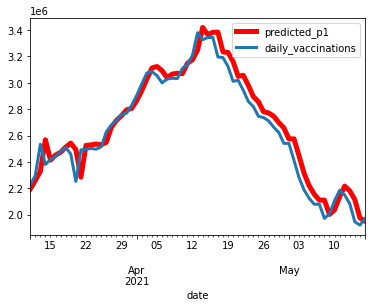

In [30]:
data_panel_test_us = data_panel_test.groupby('date').sum()
ax1 = data_panel_test_us.plot(y = 'predicted_p1', color = 'red', linewidth = 5)
data_panel_test_us.plot(y = 'daily_vaccinations', ax = ax1, linewidth = 3)
plt.show()

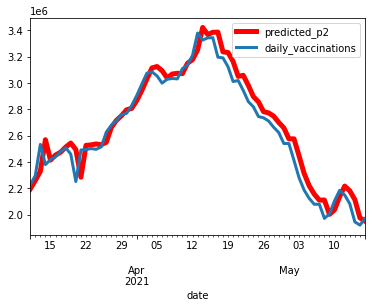

In [31]:
ax2 = data_panel_test_us.plot(y = 'predicted_p2', color = 'red', linewidth = 5)
data_panel_test_us.plot(y = 'daily_vaccinations', ax = ax2, linewidth = 3)
plt.show()

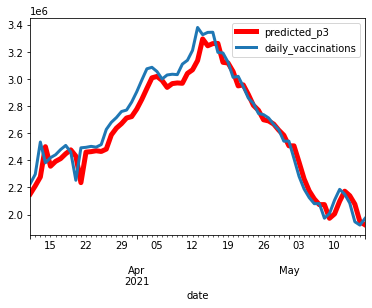

In [32]:
ax3 = data_panel_test_us.plot(y = 'predicted_p3', color = 'red', linewidth = 5)
data_panel_test_us.plot(y = 'daily_vaccinations', ax = ax3, linewidth = 3)
plt.show()

In [33]:
data_panel_test_us

,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,daily_vaccinations_lagged,predicted_p1,predicted_p2,predicted_p3
date,,,,,,,,,,,,,,,,
2021-03-11,98465249.0,132343895.0,64008756.0,658.40,1881.51,33857608.0,1209.30,2644.55,2488801.0,2227346.0,410068.0,43.452,2163603.0,2.195039e+06,2.195946e+06,2.151496e+06
2021-03-12,101399925.0,134576960.0,65899357.0,681.17,1937.86,34997779.0,1245.49,2681.15,2934676.0,2297128.0,422884.0,44.131,2227346.0,2.259221e+06,2.260217e+06,2.211433e+06
2021-03-13,105984329.0,137086100.0,68818317.0,714.05,2013.74,36922888.0,1292.14,2717.01,4584404.0,2534918.0,456970.0,45.234,2297128.0,2.329484e+06,2.330577e+06,2.277048e+06
2021-03-14,107353763.0,137087270.0,69724134.0,726.26,2044.22,37459021.0,1311.48,2717.00,1369434.0,2381503.0,441139.0,45.929,2534918.0,2.568914e+06,2.570337e+06,2.500639e+06
2021-03-15,109365206.0,137087270.0,70994461.0,740.91,2077.20,38323570.0,1332.06,2717.00,2011443.0,2419317.0,441973.0,46.688,2381503.0,2.414441e+06,2.415651e+06,2.356385e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12,264829930.0,338787670.0,153535257.0,2097.55,4696.54,117440884.0,2702.00,6039.81,1542309.0,2150130.0,344852.0,46.577,2185741.0,2.217329e+06,2.218267e+06,2.172312e+06
2021-05-13,266765002.0,340863850.0,154181269.0,2121.98,4732.42,118786491.0,2714.46,6076.67,1935072.0,2083713.0,345552.0,46.649,2150130.0,2.181473e+06,2.182361e+06,2.138828e+06
2021-05-14,268599919.0,343564350.0,154802982.0,2141.90,4761.70,120050600.0,2724.72,6113.26,1834917.0,1946507.0,314732.0,46.655,2083713.0,2.114598e+06,2.115394e+06,2.076377e+06


### Stock Price

#### Linear Regression

In [34]:
case_confirmed_state = case_confirmed.groupby('Province_State').sum()
case_confirmed_state = case_confirmed_state.iloc[:,5:]
case_confirmed_state = case_confirmed_state.transpose()
case_confirmed_state['cases_confirm'] = case_confirmed_state.sum(axis = 1)
case_confirmed_us = pd.DataFrame(case_confirmed_state['cases_confirm'])

In [35]:
case_confirmed_us.index.name = 'date'
case_confirmed_us = case_confirmed_us.reset_index()
case_confirmed_us.date = pd.to_datetime(case_confirmed_us.date, format = '%m/%d/%y')
case_confirmed_us = case_confirmed_us.set_index('date')

In [36]:
case_confirmed_us

,cases_confirm
date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2021-05-23,33117737
2021-05-24,33143662
2021-05-25,33166418


In [37]:
case_death_state = case_death.groupby('Province_State').sum()
case_death_state = case_death_state.iloc[:,6:]
case_death_state = case_death_state.transpose()
case_death_state['cases_death'] = case_death_state.sum(axis = 1)
case_death_us = pd.DataFrame(case_death_state['cases_death'])

In [38]:
case_death_us.index.name = 'date'
case_death_us = case_death_us.reset_index()
case_death_us.date = pd.to_datetime(case_death_us.date, format = '%m/%d/%y')
case_death_us = case_death_us.set_index('date')

In [39]:
case_death_us

,cases_death
date,
2020-01-22,1
2020-01-23,1
2020-01-24,1
2020-01-25,1
2020-01-26,1
...,...
2021-05-23,589893
2021-05-24,590320
2021-05-25,590941


In [40]:
PFE = pfe.join(case_confirmed_us, how = 'left')
PFE = PFE.join(case_death_us, how = 'left')
PFE = PFE.join(Pf_manu, how = 'left')
PFE = PFE.join(data_panel_test_us, how = 'left', lsuffix = '_manu', rsuffix = '_inject')
PFE = PFE.fillna(0)
# PFE= PFE.rename(columns={'adj close': 'adjclose'})

In [41]:
MOD = mrna.join(case_confirmed_us, how = 'left')
MOD = MOD.join(case_death_us, how = 'left')
MOD = MOD.join(Mod_manu, how = 'left')
MOD = MOD.join(data_panel_test_us, how = 'left', lsuffix = '_manu', rsuffix = '_inject')
MOD = MOD.fillna(0)
# MOD = MOD.rename(columns={'adj close': 'adjclose'})

In [42]:
JJ = jnj.join(case_confirmed_us, how = 'left')
JJ = JJ.join(case_death_us, how = 'left')
JJ = JJ.join(JJ_manu, how = 'left')
JJ = JJ.join(data_panel_test_us, how = 'left', lsuffix = '_manu', rsuffix = '_inject')
JJ = JJ.fillna(0)
# JJ = JJ.rename(columns={'adj close': 'adjclose'})

In [43]:
res_pfe = sm.ols(formula = 'adjclose ~ cases_confirm + cases_death\
 + total_vaccinations_manu + predicted_p2', data = PFE).fit()
res_pfe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     59.58
Date:                Fri, 28 May 2021   Prob (F-statistic):           5.89e-37
Time:                        05:48:37   Log-Likelihood:                -650.04
No. Observations:                 304   AIC:                             1310.
Df Residuals:                     299   BIC:                             1329.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  31.0506      0.342     90.867      0.000      30.378      31.723
cases_confirm           -1.872e-07   7.03e-08     -2.664      0.008   -3.25e-07   -4.89e-08
cases_death              2.165e-05   4.43e-06      4.884      0.000    1.29e-05    3.04e-05
total_vaccinations_manu  2.247e-09   8.52e-09      0.264      0.792   -1.45e-08     1.9e-08
predicted_p2            -1.569e-07   2.78e-07     -0.563      0.574   -7.05e-07    3.91e-07
==============================================================================
Omnibus:                        5.592   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                6.265
Skew:                           0.194   Prob(JB):                       0.0436
Kurtosis:                       3.587   Cond. No.                     1.25e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
PFE_partial = PFE.loc[PFE.index >= '2021-03-11']
res_pfe_partial = sm.ols(formula = 'adjclose ~ cases_confirm + cases_death\
 + total_vaccinations_manu + predicted_p2', data = PFE_partial).fit()
res_pfe_partial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     154.2
Date:                Fri, 28 May 2021   Prob (F-statistic):           3.95e-24
Time:                        05:48:37   Log-Likelihood:                -27.455
No. Observations:                  46   AIC:                             64.91
Df Residuals:                      41   BIC:                             74.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  11.3037     80.651      0.140      0.889    -151.573     174.181
cases_confirm            4.131e-06   3.71e-06      1.112      0.273   -3.37e-06    1.16e-05
cases_death                -0.0002    7.9e-05     -2.275      0.028      -0.000   -2.02e-05
total_vaccinations_manu -8.422e-09    1.2e-07     -0.070      0.944    -2.5e-07    2.33e-07
predicted_p2            -4.693e-07   3.83e-07     -1.226      0.227   -1.24e-06    3.04e-07
==============================================================================
Omnibus:                        0.755   Durbin-Watson:                   0.673
Prob(Omnibus):                  0.686   Jarque-Bera (JB):                0.853
Skew:                           0.244   Prob(JB):                        0.653
Kurtosis:                       2.544   Cond. No.                     1.26e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

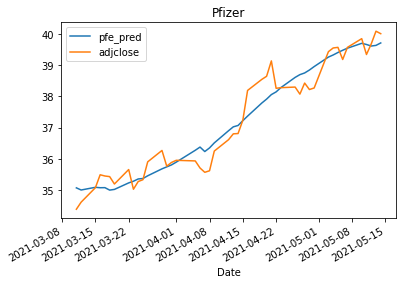

In [45]:
pfe_pred = res_pfe_partial.predict(PFE_partial[['cases_confirm', 'cases_death', 'total_vaccinations_manu', 'predicted_p2']])
PFE_partial['pfe_pred'] = pfe_pred
_ = PFE_partial.plot(y = ['pfe_pred', 'adjclose'])
_ = plt.title('Pfizer')

In [46]:
res_mod = sm.ols(formula = 'adjclose ~ cases_confirm + cases_death\
 + total_vaccinations_manu + predicted_p2', data = MOD).fit()
res_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     513.1
Date:                Fri, 28 May 2021   Prob (F-statistic):          3.03e-132
Time:                        05:48:38   Log-Likelihood:                -1275.5
No. Observations:                 303   AIC:                             2561.
Df Residuals:                     298   BIC:                             2580.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  37.4643      2.723     13.761      0.000      32.106      42.822
cases_confirm            2.266e-06   5.58e-07      4.059      0.000    1.17e-06    3.37e-06
cases_death                 0.0001   3.52e-05      3.526      0.000    5.48e-05       0.000
total_vaccinations_manu -6.386e-08   9.05e-08     -0.706      0.481   -2.42e-07    1.14e-07
predicted_p2             -7.49e-06   2.39e-06     -3.133      0.002   -1.22e-05   -2.79e-06
==============================================================================
Omnibus:                       40.350   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.226
Skew:                           0.850   Prob(JB):                     2.27e-13
Kurtosis:                       4.311   Cond. No.                     1.08e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
MOD_partial = MOD.loc[MOD.index >= '2021-03-11']
res_mod_partial = sm.ols(formula = 'adjclose ~ cases_confirm + cases_death\
 + total_vaccinations_manu + predicted_p2', data = MOD_partial).fit()
res_mod_partial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     36.60
Date:                Fri, 28 May 2021   Prob (F-statistic):           7.17e-13
Time:                        05:48:38   Log-Likelihood:                -158.33
No. Observations:                  45   AIC:                             326.7
Df Residuals:                      40   BIC:                             335.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1040.9477   1467.837      0.709      0.482   -1925.663    4007.558
cases_confirm               0.0002   5.02e-05      3.030      0.004    5.07e-05       0.000
cases_death                -0.0100      0.001     -7.080      0.000      -0.013      -0.007
total_vaccinations_manu -2.507e-07   2.89e-06     -0.087      0.931   -6.09e-06    5.59e-06
predicted_p2             8.015e-06   4.47e-06      1.792      0.081   -1.02e-06    1.71e-05
==============================================================================
Omnibus:                        3.611   Durbin-Watson:                   0.849
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                2.082
Skew:                          -0.280   Prob(JB):                        0.353
Kurtosis:                       2.108   Cond. No.                     1.04e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

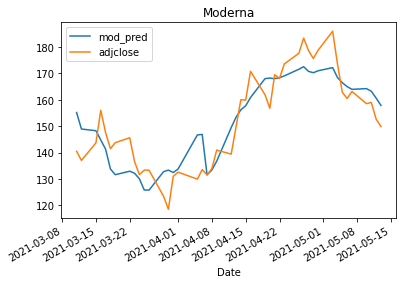

In [48]:
mod_pred = res_mod_partial.predict(MOD_partial[['cases_confirm', 'cases_death', 'total_vaccinations_manu', 'predicted_p2']])
MOD_partial['mod_pred'] = mod_pred
_ = MOD_partial.plot(y = ['mod_pred', 'adjclose'])
_ = plt.title('Moderna')

In [49]:
res_jj = sm.ols(formula = 'adjclose ~ cases_confirm + cases_death\
 + total_vaccinations_manu + predicted_p2', data = JJ).fit()
res_jj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     271.1
Date:                Fri, 28 May 2021   Prob (F-statistic):           4.06e-98
Time:                        05:48:38   Log-Likelihood:                -927.06
No. Observations:                 304   AIC:                             1864.
Df Residuals:                     299   BIC:                             1883.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 132.7907      0.844    157.341      0.000     131.130     134.452
cases_confirm           -2.563e-07   1.73e-07     -1.478      0.141   -5.98e-07     8.5e-08
cases_death              7.138e-05    1.1e-05      6.474      0.000    4.97e-05    9.31e-05
total_vaccinations_manu  4.785e-07   2.58e-07      1.853      0.065   -2.96e-08    9.87e-07
predicted_p2            -1.856e-06   6.64e-07     -2.794      0.006   -3.16e-06   -5.49e-07
==============================================================================
Omnibus:                       49.768   Durbin-Watson:                   0.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.469
Skew:                          -0.775   Prob(JB):                     9.37e-28
Kurtosis:                       5.725   Cond. No.                     4.92e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
JJ_partial = JJ.loc[JJ.index >= '2021-03-11']
res_jj_partial = sm.ols(formula = 'adjclose ~ cases_confirm + cases_death\
 + total_vaccinations_manu + predicted_p2', data = JJ_partial).fit()
res_jj_partial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     30.97
Date:                Fri, 28 May 2021   Prob (F-statistic):           6.68e-12
Time:                        05:48:38   Log-Likelihood:                -85.339
No. Observations:                  46   AIC:                             180.7
Df Residuals:                      41   BIC:                             189.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -49.6883     49.033     -1.013      0.317    -148.713      49.337
cases_confirm           -3.997e-06   4.81e-06     -0.831      0.411   -1.37e-05    5.71e-06
cases_death                 0.0006      0.000      2.231      0.031    5.88e-05       0.001
total_vaccinations_manu -1.022e-06   6.83e-07     -1.496      0.142    -2.4e-06    3.58e-07
predicted_p2             -2.27e-06      1e-06     -2.266      0.029   -4.29e-06   -2.47e-07
==============================================================================
Omnibus:                        1.677   Durbin-Watson:                   0.717
Prob(Omnibus):                  0.432   Jarque-Bera (JB):                1.083
Skew:                           0.370   Prob(JB):                        0.582
Kurtosis:                       3.135   Cond. No.                     6.48e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.48e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

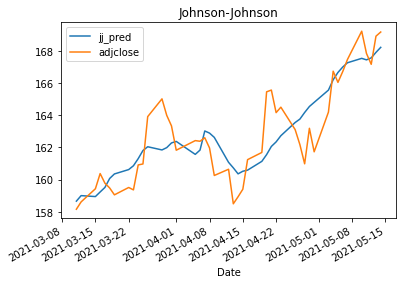

In [51]:
jj_pred = res_jj_partial.predict(JJ_partial[['cases_confirm', 'cases_death', 'total_vaccinations_manu', 'predicted_p2']])
JJ_partial['jj_pred'] = jj_pred
_ = JJ_partial.plot(y = ['jj_pred', 'adjclose'])
_ = plt.title('Johnson-Johnson')

#### Elastic Net

In [52]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [53]:
PFE_partial.shape

(46, 29)

In [54]:
PFE_partial_train = PFE_partial.iloc[:36,:]
PFE_partial_test = PFE_partial.iloc[36:,:]
MOD_partial_train = MOD_partial.iloc[:36,:]
MOD_partial_test = MOD_partial.iloc[36:,:]
JJ_partial_train = JJ_partial.iloc[:36,:]
JJ_partial_test = JJ_partial.iloc[36:,:]

In [55]:
# function to find mean-squared-error
def IOMSE_PFE(Lambda):
  l = Lambda
  mse = np.empty(shape=3)
  for i in range(0, 3):
      data_os = PFE_partial_train.iloc[
          i * 12 : (i + 1) * 12, :
      ]  # out of sample 12 sets of data

      data_is = PFE_partial_train.iloc[
          np.concatenate([range(0, i * 12), range((i + 1) * 12, 36)]), :
      ]  # in sample 24 sets of data

      mse_temp = mean_squared_error(
          data_os.iloc[:, 4],
          ElasticNet(l, l1_ratio=0.5, fit_intercept=False)
          .fit(X=data_is.iloc[:,[6,7,9, 23]], y=data_is.iloc[:, 4])
          .predict(data_os.iloc[:,[6,7,9, 23]]),
      )
      mse[i] = mse_temp

  mse_m = np.mean(mse)
  return mse_m

mse_baseline_pfe = np.mean(np.square((PFE_partial_test.iloc[:, 4] - np.mean(PFE_partial_test.iloc[:, 4]))))

opt_pfe = minimize(fun=IOMSE_PFE, x0=0.01)
lambda_opt_pfe = opt_pfe.x
mse_els_pfe = mean_squared_error(PFE_partial_test.iloc[:,4], ElasticNet(lambda_opt_pfe, l1_ratio = 0.5, fit_intercept = False)\
.fit(X = PFE_partial_train.iloc[:, [6,7,9, 23]], y = PFE_partial_train.iloc[:,4])\
.predict(X = PFE_partial_test.iloc[:, [6,7,9, 23]]))
PseudoR2_els_pfe = 1 - mse_els_pfe / mse_baseline_pfe

print("The optimal lambda is " + str(float(lambda_opt_pfe)) + ".")
print("The MSE of the prediction using ElasticNet is " + str(mse_els_pfe) + ". ")
print("The MSE of the baseline is " + str(mse_baseline_pfe) + ". ")
print("The Pseudo_R2 using ElasticNet is " + str(PseudoR2_els_pfe) + ". ")

The optimal lambda is 0.01.
The MSE of the prediction using ElasticNet is 0.20560925781751654. 
The MSE of the baseline is 0.0746442563562104. 
The Pseudo_R2 using ElasticNet is -1.7545221542073794. 


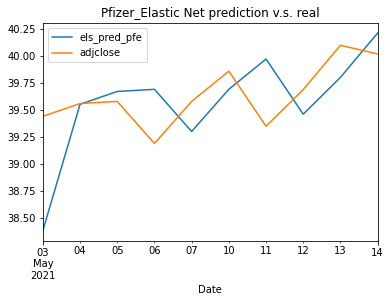

In [56]:
els_pred_pfe = ElasticNet(lambda_opt_pfe, l1_ratio = 0.5, fit_intercept = False)\
.fit(X = PFE_partial_train.iloc[:, [6, 7, 9, 23]], y = PFE_partial_train.iloc[:,4])\
.predict(X = PFE_partial_test.iloc[:, [6, 7, 9, 23]])
PFE_partial_test['els_pred_pfe'] = els_pred_pfe
_ = PFE_partial_test.plot(y = ['els_pred_pfe', 'adjclose'])
_ = plt.title("Pfizer_Elastic Net prediction v.s. real")

In [57]:
# function to find mean-squared-error
def IOMSE_MOD(Lambda):
  l = Lambda
  mse = np.empty(shape=3)
  for i in range(0, 3):
      data_os = MOD_partial_train.iloc[
          i * 12 : (i + 1) * 12, :
      ]  # out of sample 12 sets of data

      data_is = MOD_partial_train.iloc[
          np.concatenate([range(0, i * 12), range((i + 1) * 12, 36)]), :
      ]  # in sample 24 sets of data

      mse_temp = mean_squared_error(
          data_os.iloc[:, 4],
          ElasticNet(l, l1_ratio=0.5, fit_intercept=False)
          .fit(X=data_is.iloc[:,[6,7,9, 23]], y=data_is.iloc[:, 4])
          .predict(data_os.iloc[:,[6,7,9, 23]]),
      )
      mse[i] = mse_temp

  mse_m = np.mean(mse)
  return mse_m

mse_baseline_mod = np.mean(np.square((MOD_partial_test.iloc[:, 4] - np.mean(MOD_partial_test.iloc[:, 4]))))

opt_mod = minimize(fun=IOMSE_MOD, x0=0.01)
lambda_opt_mod = opt_mod.x
mse_els_mod = mean_squared_error(MOD_partial_test.iloc[:,4], ElasticNet(lambda_opt_mod, l1_ratio = 0.5, fit_intercept = False)\
.fit(X = MOD_partial_train.iloc[:, [6,7,9, 23]], y = MOD_partial_train.iloc[:,4])\
.predict(X = MOD_partial_test.iloc[:, [6,7,9, 23]]))
PseudoR2_els_mod = 1 - mse_els_mod / mse_baseline_mod

print("The optimal lambda is " + str(float(lambda_opt_mod)) + ".")
print("The MSE of the prediction using ElasticNet is " + str(mse_els_mod) + ". ")
print("The MSE of the baseline is " + str(mse_baseline_mod) + ". ")
print("The Pseudo_R2 using ElasticNet is " + str(PseudoR2_els_mod) + ". ")

The optimal lambda is 0.0001110067787287631.
The MSE of the prediction using ElasticNet is 2.188939930013598. 
The MSE of the baseline is 107.00843393113003. 
The Pseudo_R2 using ElasticNet is 0.9795442298368521. 


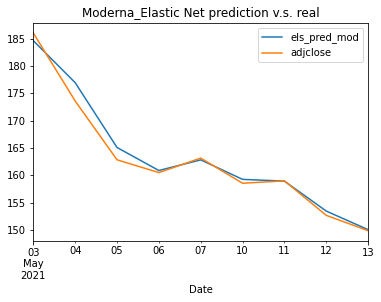

In [58]:
els_pred_mod = ElasticNet(lambda_opt_mod, l1_ratio = 0.5, fit_intercept = False)\
.fit(X = MOD_partial_train.iloc[:, [6, 7, 9, 23]], y = MOD_partial_train.iloc[:,4])\
.predict(X = MOD_partial_test.iloc[:, [6, 7, 9, 23]])
MOD_partial_test['els_pred_mod'] = els_pred_mod
_ = MOD_partial_test.plot(y = ['els_pred_mod', 'adjclose'])
_ = plt.title("Moderna_Elastic Net prediction v.s. real")

In [59]:
# function to find mean-squared-error
def IOMSE_JJ(Lambda):
  l = Lambda
  mse = np.empty(shape=3)
  for i in range(0, 3):
      data_os = JJ_partial_train.iloc[
          i * 12 : (i + 1) * 12, :
      ]  # out of sample 12 sets of data

      data_is = JJ_partial_train.iloc[
          np.concatenate([range(0, i * 12), range((i + 1) * 12, 36)]), :
      ]  # in sample 24 sets of data

      mse_temp = mean_squared_error(
          data_os.iloc[:, 4],
          ElasticNet(l, l1_ratio=0.5, fit_intercept=False)
          .fit(X=data_is.iloc[:,[6,7,9, 23]], y=data_is.iloc[:, 4])
          .predict(data_os.iloc[:,[6,7,9, 23]]),
      )
      mse[i] = mse_temp

  mse_m = np.mean(mse)
  return mse_m

mse_baseline_jj = np.mean(np.square((JJ_partial_test.iloc[:, 4] - np.mean(JJ_partial_test.iloc[:, 4]))))

opt_jj = minimize(fun=IOMSE_JJ, x0=0.01)
lambda_opt_jj = opt_jj.x
mse_els_jj = mean_squared_error(JJ_partial_test.iloc[:,4], ElasticNet(lambda_opt_jj, l1_ratio = 0.5, fit_intercept = False)\
.fit(X = JJ_partial_train.iloc[:, [6,7,9, 23]], y = JJ_partial_train.iloc[:,4])\
.predict(X = JJ_partial_test.iloc[:, [6,7,9, 23]]))
PseudoR2_els_jj = 1 - mse_els_jj / mse_baseline_jj

print("The optimal lambda is " + str(float(lambda_opt_jj)) + ".")
print("The MSE of the prediction using ElasticNet is " + str(mse_els_jj) + ". ")
print("The MSE of the baseline is " + str(mse_baseline_jj) + ". ")
print("The Pseudo_R2 using ElasticNet is " + str(PseudoR2_els_jj) + ". ")

The optimal lambda is -1.8423871684476791.
The MSE of the prediction using ElasticNet is 2.353647738261273. 
The MSE of the baseline is 2.202184765983441. 
The Pseudo_R2 using ElasticNet is -0.06877850333788516. 


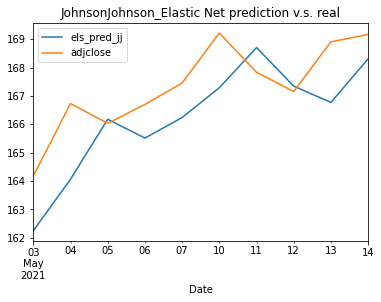

In [60]:
els_pred_jj = ElasticNet(lambda_opt_jj, l1_ratio = 0.5, fit_intercept = False)\
.fit(X = JJ_partial_train.iloc[:, [6, 7, 9, 23]], y = JJ_partial_train.iloc[:,4])\
.predict(X = JJ_partial_test.iloc[:, [6, 7, 9, 23]])
JJ_partial_test['els_pred_jj'] = els_pred_jj
_ = JJ_partial_test.plot(y = ['els_pred_jj', 'adjclose'])
_ = plt.title("JohnsonJohnson_Elastic Net prediction v.s. real")